In [120]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)

filename = 'facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [121]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', ..., 'NOLAN',
                          'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']

This data is from the Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate.

In [122]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [123]:
PE_mask = training_data['PE'].notnull().values
training_data = training_data[PE_mask]

Drop the feature vectors that don't have a valid PE entry.

In [124]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

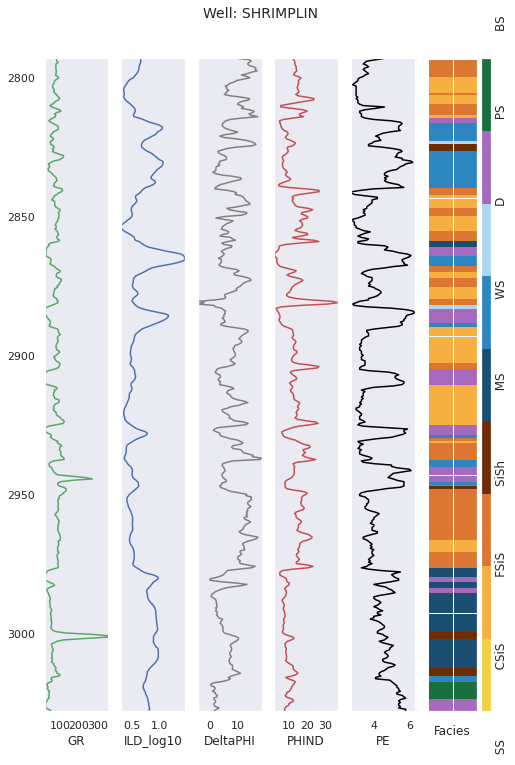

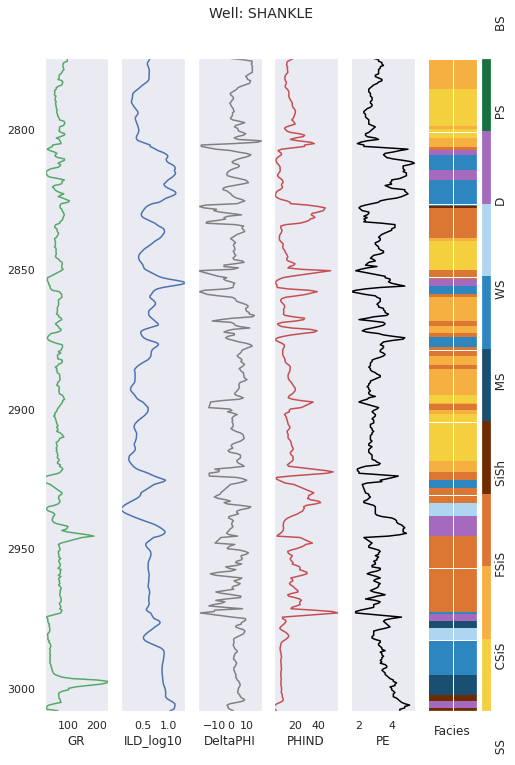

In [125]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHANKLE'],
    facies_colors)



Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type. This dataset contains 5 log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset. We can employ the very useful Seaborn library to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies. The same colormap is used to represent the 9 facies.

/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


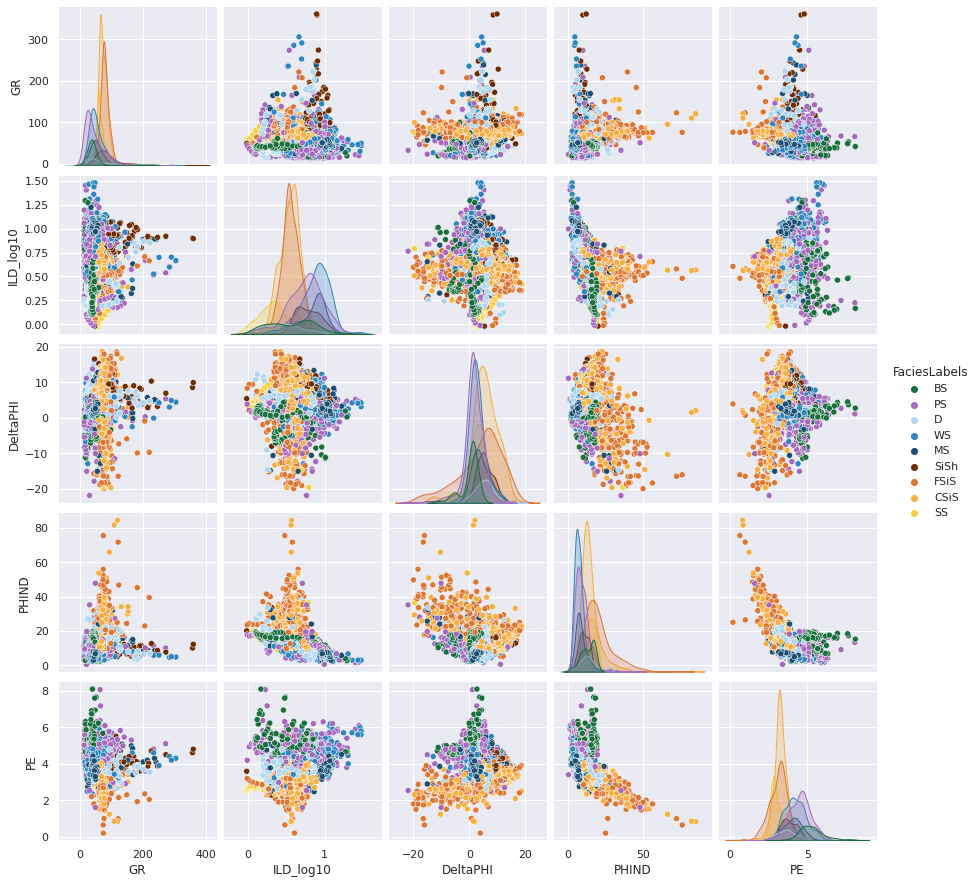

In [126]:
inline_rc = dict(mpl.rcParams)
import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

In [127]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [128]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [129]:
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

clf = svm.SVC()

In [130]:
clf.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [131]:
predicted_labels = clf.predict(X_test)

In [132]:
from sklearn.metrics import confusion_matrix


conf = confusion_matrix(y_test, predicted_labels)
conf


array([[ 24,  20,   2,   0,   0,   0,   0,   0,   0],
       [  2, 114,  36,   0,   0,   0,   1,   0,   0],
       [  2,  31,  90,   1,   1,   1,   0,   0,   0],
       [  0,   0,   2,  18,   0,   7,   0,   1,   0],
       [  0,   2,   1,   3,   1,  29,   1,  10,   0],
       [  0,   0,   0,  11,   0,  69,   1,  18,   1],
       [  0,   0,   0,   1,   0,   1,   9,  11,   0],
       [  0,   0,   1,   6,   2,  15,   3,  65,   2],
       [  0,   0,   0,   0,   0,   0,   0,   7,  24]])

In [133]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [134]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [135]:
print ('Facies classification accuracy = %f' % accuracy(conf))
print ('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.639876
Adjacent facies classification accuracy = 0.916538


In [136]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']


facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

In [137]:
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [138]:
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


In [139]:
well_names = training_data['Well Name'].unique()
well_names

['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (8, object): ['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9',
                         'NEWBY', 'CHURCHMAN BIBLE']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


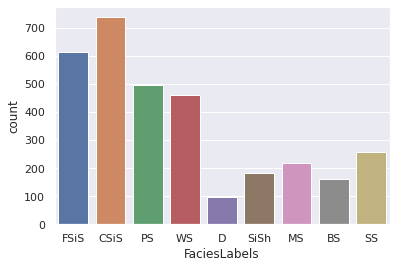

In [140]:
import seaborn as sns
sns.countplot(training_data.FaciesLabels)

In [145]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 20)
pd.options.mode.chained_assignment = None

seed = 101
np.random.seed(seed)

filename = 'facies_vectors.csv'
data = pd.read_csv(filename)
training_data = data.copy()

In [146]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']
Categories (10, object): ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', ..., 'NOLAN',
                          'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE']

In [148]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
      logs = logs.sort_values(by='Depth')
      cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [149]:
from sklearn import __version__ as sklearn_version
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [151]:
from sklearn.impute import SimpleImputer
def feat_imput(training_data, drop_columns):
    """adopted RandomForest feature regressor by ar4"""
    #imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    #X = training_data.drop(drop_columns, axis=1).values
    #X_imputed = imp.fit_transform(X)
    training_data_imputed = training_data.copy()
    #for ift,ft in enumerate(training_data.columns.drop(drop_columns)):
    #    training_data_imputed[ft] = X_imputed[:,ift]
        
    reg = RandomForestRegressor(max_features='sqrt', n_estimators=50)
    feat_labels =training_data.columns.drop(drop_columns)
    DataImpAll = training_data[feat_labels].copy()
    DataImp = DataImpAll.dropna(axis = 0, inplace=False)
    Ximp=DataImp.loc[:, DataImp.columns != 'PE']
    Yimp=DataImp.loc[:, 'PE']
    Y_PE = DataImpAll.loc[:, 'PE']
    reg.fit(Ximp, Yimp)
    Y_PE[DataImpAll.PE.isnull()] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False)) 
    training_data_imputed['PE'] = Y_PE
    #X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:].drop('PE',axis=1,inplace=False))    
    
    return training_data_imputed

In [152]:
drop_columns= ['Formation', 'Well Name', 'Depth','Facies']
depth = training_data['Depth']
well = data['Well Name'].values
training_data = feat_imput(training_data,drop_columns)

In [153]:
def add_del(df,feat_names, depth, thesh = 1e-3):
    """"""
    for fn in feat_names:
        df["del_"+fn] = np.gradient(df[fn] )/np.gradient(depth)
    return df
def add_features(training_data,drop_columns,depth):
    """"""
    xx = add_del(training_data,[fn for fn in training_data.columns.drop(drop_columns) if fn != 'NM_M'], depth)
    xx = add_del(xx,[fn for fn in xx.columns.drop(drop_columns) if fn != 'NM_M'],depth)
    return xx
training_data.columns[4:]
training_data = add_del(training_data,[fn for fn in training_data.columns[4:] if fn != 'NM_M'],depth)
training_data = add_del(training_data,[fn for fn in training_data.columns[4:] if fn != 'NM_M'],depth)
training_data.columns[4:]
feat_labels =training_data.columns.drop(drop_columns)

In [154]:
feat_labels

Index(['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS',
       'del_GR', 'del_ILD_log10', 'del_DeltaPHI', 'del_PHIND', 'del_PE',
       'del_RELPOS', 'del_del_GR', 'del_del_ILD_log10', 'del_del_DeltaPHI',
       'del_del_PHIND', 'del_del_PE', 'del_del_RELPOS'],
      dtype='object')

In [155]:
y = training_data['Facies'].values -1
X = training_data.drop(['Formation', 'Well Name', 'Depth','Facies'], axis=1).values
feat_labels =training_data.columns[4:]
label_encoded_y  = np.unique(y)

In [156]:
from sklearn.model_selection import LeavePGroupsOut
# Initialize model selection methods
lpgo = LeavePGroupsOut(2)
Xf = data[data.columns[4:]].values
yf = data['Facies'].values
custom_cv_list = []
# Generate splits
split_list = []
for train, val in lpgo.split(Xf, yf, groups=training_data['Well Name']):
    hist_tr = np.histogram(yf[train], bins=np.arange(len(facies_labels)+1)+.5)
    hist_val = np.histogram(yf[val], bins=np.arange(len(facies_labels)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
        
custom_cv = [(np.arange(len(yf)),np.arange(len(yf)))]            

In [159]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import make_scorer
# create custom scorer

def my_scorer(clf,X,y):
    """"""
    score_split = []
 
        
    for split in split_list:
       
        # Select training and validation data from current split
        X_tr = X[split['train'],:]
        X_v = X[split['val'], :]
        y_tr = y[split['train']]
        y_v = y[split['val']]
        
        # Select well labels for validation data
        well_v = well[split['val']]

        # Train and test
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_v)

        # Score
        score = f1_score(y_v, y_pred, average='micro')
        score_split.append(score)
        
    # Average score 
    return np.mean(score_split)  
pre_scorer = make_scorer(my_scorer, greater_is_better=True)

# random forest (the tuneup of hyperparameters was done with gridsearchCV)
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( 
    n_estimators = 303,
    min_samples_leaf =1,
    random_state=seed, n_jobs=6)
print('Predicted F1-Score: {}'.format(my_scorer(forest,X,y)))

Predicted F1-Score: 0.5521563616917441


In [160]:
#XGBoosted trees
import xgboost as xgb
from xgboost import XGBClassifier
xg = XGBClassifier(learning_rate =0.05,
 n_estimators=331,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.6,
 colsample_bytree=0.8,
 reg_alpha=0.25,
 nthread=-1,
 objective='multi:softprob',
 scale_pos_weight=1,
 seed=seed)

xg.fit(X, y)
#y_pred = xg2.predict(X_test)
#print ("F1-score: %.4g" % f1_score(y_test,y_pred, average='micro'))
print ("F1-score: %.4g" % my_scorer(xg,X,y))


F1-score: 0.5603
